# Full object detection

## Imports

In [55]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
from keras.utils.np_utils import to_categorical
from cnn import CommitteeOfCNNs
from utils import ModelSaver, showScaledImage
from objectdetection import ObjectDetector
from preprocessing import preprocessMany, applyHistogramNormalization, applyHOG, resizeMany, applyNormalization
import time
import cv2

In [48]:
plt.rcParams["figure.figsize"] = (10, 10)

## Load data

### German traffic sign dataset

In [4]:
path = './data/'

In [2]:
data = ModelSaver(path + 'preprocessed_hist').load()
data.keys()

dict_keys(['x', 'y', 'labels'])

In [5]:
labels = ModelSaver(path + 'labels').load()

In [3]:
labels = data['labels']

yTrain = to_categorical(data['y']['train'], num_classes=43)
yTest = to_categorical(data['y']['test'], num_classes=43)
yValid = to_categorical(data['y']['valid'], num_classes=43)

xTrainSimple = data['x']['train']['simple']
xTestSimple = data['x']['test']['simple']
xValidSimple = data['x']['valid']['simple']

xTrainStretch = data['x']['train']['stretch']
xTestStretch = data['x']['test']['stretch']
xValidStretch = data['x']['valid']['stretch']

xTrainEq = data['x']['train']['eq']
xTestEq = data['x']['test']['eq']
xValidEq = data['x']['valid']['eq']

xTrainAdEq = data['x']['train']['adeq']
xTestAdEq = data['x']['test']['adeq']
xValidAdEq = data['x']['valid']['adeq']

xTrainHOG = np.array(data['x']['train']['hog'])
xTestHOG = np.array(data['x']['test']['hog'])
xValidHOG = np.array(data['x']['valid']['hog'])

In [4]:
dataSets = np.array([
    [xTrainSimple,  yTrain, xValidSimple,  yValid, xTestSimple,  yTest],
    [xTrainStretch, yTrain, xValidStretch, yValid, xTestStretch, yTest],
    [xTrainEq,      yTrain, xValidEq,      yValid, xTestEq,      yTest],
    [xTrainAdEq,    yTrain, xValidAdEq,    yValid, xTestAdEq,    yTest],
    [xTrainHOG,     yTrain, xValidHOG,     yValid, xTestHOG,     yTest]
])

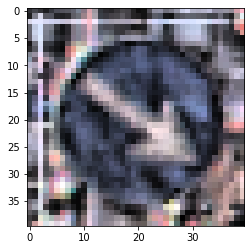

In [6]:
showScaledImage(xTrainAdEq[0])

### Teó dataset

In [6]:
data = ModelSaver(path + 'signs').load()
images = data['images']

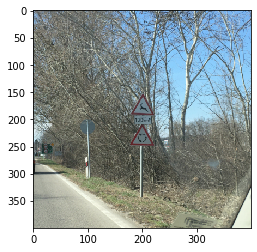

In [32]:
plt.imshow(images[12])

In [69]:
def cropImage(img):
    w, h = img.shape[1], img.shape[0]
    wh = min(w, h)
    x1, y1 = (w - wh) / 2, (h - wh) / 2
    x2, y2 = x1 + w, y1 + h
    x1, x2, y1, y2 = int(x1), int(x2), int(y1), int(y2)
    return img[y1:y2, x1:x2], x1, y1

def loadImage(path):
    im = cv2.imread(path, cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    im = im.astype('float32')
    im = im / 255.0
    return im

## Commitee of Cnns

In [8]:
model = CommitteeOfCNNs()
model.load()

In [9]:
model.evaluate(dataSets)

Accuracy: 0.9286619424819946
Accuracy: 0.8999208211898804
Accuracy: 0.948693573474884
Accuracy: 0.956136167049408
Accuracy: 0.9094220399856567


In [10]:
model.test(dataSets[:, 4], yTest)

0.9828978622327791

In [14]:
labels[model.predict([xTestSimple[0], xTestStretch[0], xTestEq[0], xTestAdEq[0], xTestHOG[0]])]

'Road work'

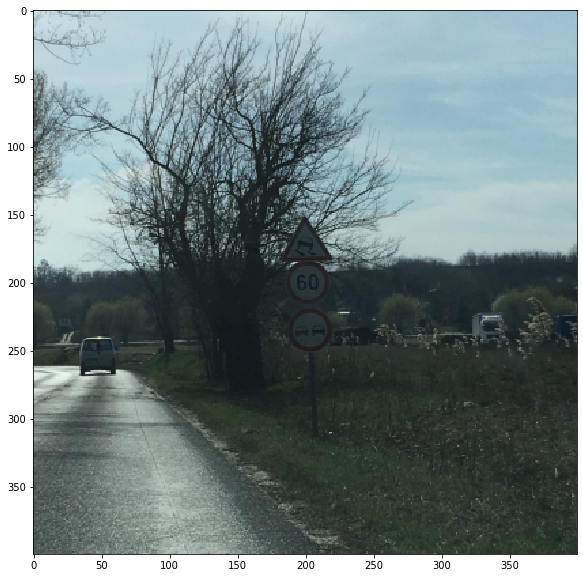

In [51]:
plt.imshow(images[0])

## Object detector

In [9]:
objectDetector = ObjectDetector()
objectDetector.load()

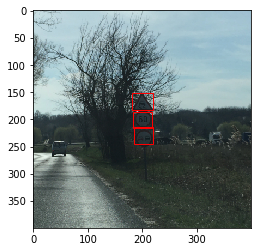

In [16]:
objectDetector.showPrediction(images[0])

## Full pipeline

In [11]:
def fullPrediction(image):
    results = objectDetector.predict(image)
    bboxes = extendBoundingBoxes(image, results)
    images = prepareImages(image, bboxes)
    predictions = []
    for i in range(0, len(results)):
        pred = model.predict([images[0][i], images[1][i], images[2][i], images[3][i], images[4][i]])
        predictions.append(pred)
    return bboxes, predictions
    
def extendBoundingBoxes(image, bboxes, value = .1):
    h, w = image.shape[:2]
    results = []
    for bbox in bboxes:
        x1, x2, y1, y2 = bbox[1:]
        bw, bh = x2 - x1, y2 - y1
        dx, dy = bw * value, bh * value
        x1 = max(0, x1 - dx)
        x2 = min(w, x2 + dx)
        y1 = max(0, y1 - dy)
        y2 = min(h, y2 + dy)
        results.append([x1, x2, y1, y2])
    return np.array(results)

def prepareImages(image, bboxes):
    imgs = []
    for bbox in bboxes:
        x1, x2, y1, y2 = bbox.astype('int')
        imgs.append(image[y1:y2, x1:x2])
    imgs = np.array(imgs)
    # Baj van, ha nem 1:1-es az eredeti kép!
    resized = resizeMany(imgs, (40, 40))
    normalized = [ applyHistogramNormalization(resized, [method]) for method in range(0, 3) ]
    preprocessed = [ applyNormalization(imgs) for imgs in np.array(normalized) ]
    preprocessed.append(applyHOG(imgs))
    preprocessed.insert(0, resized)
    return preprocessed

In [46]:
def showFullPrediction(image):
    start = time.time()
    bboxes, label = fullPrediction(image)
    end = time.time()
    print('Object detection took', int((end - start) * 1000), 'ms')
    fig, ax = plt.subplots(1)
    
    ax.imshow(applyHistogramNormalization([image], [1])[0])
    for i in range(0, len(bboxes)):
        pred = bboxes[i]
        x1, x2, y1, y2 = pred
        x, y = x1, y1
        w, h = x2 - x1, y2 - y1
        rect = patches.Rectangle((x, y),w, h,linewidth=1,edgecolor='r',facecolor='none')
        ax.text(x2, y, labels[label[i]], bbox=dict(facecolor='red'))
        ax.add_patch(rect)
    plt.show()

In [73]:
testimg = loadImage('../traffic-signs-server/src/assets/testimage3.png')

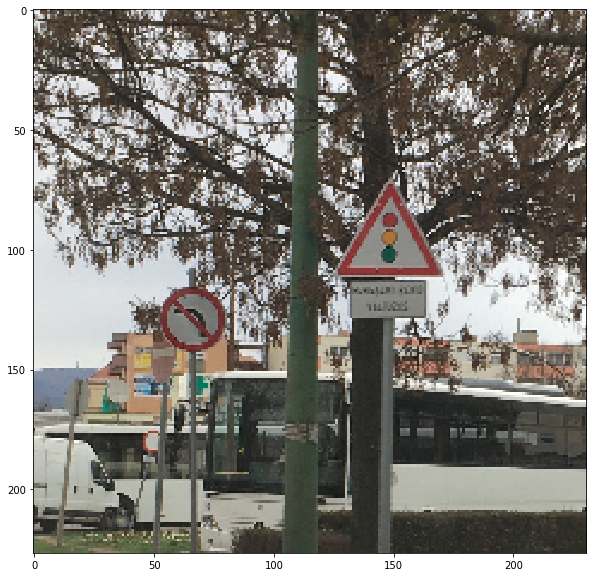

In [74]:
plt.imshow(testimg)

Object detection took 444 ms


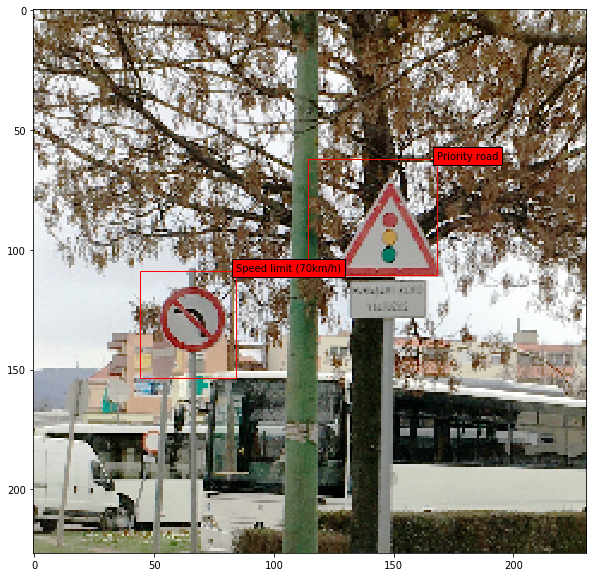

In [78]:
showFullPrediction(testimg)